***1***

     pcost       dcost       gap    pres   dres
 0:  1.4300e+05 -1.0244e+08  3e+08  7e-01  8e-12
 1:  4.4168e+05 -2.1701e+07  3e+07  6e-02  7e-12
 2:  3.9694e+05 -3.4388e+06  5e+06  7e-03  5e-12
 3:  8.2555e+04 -4.6866e+05  6e+05  3e-04  3e-12
 4:  4.4627e+02 -7.1675e+04  7e+04  6e-06  3e-12
 5: -3.4123e+03 -1.3007e+04  1e+04  7e-07  3e-12
 6: -3.7703e+03 -1.3286e+04  1e+04  7e-07  3e-12
 7: -3.4728e+03 -1.2845e+04  9e+03  6e-07  3e-12
 8: -4.1575e+03 -1.1341e+04  7e+03  4e-07  4e-12
 9: -4.4373e+03 -1.1084e+04  7e+03  3e-07  4e-12
10: -4.1750e+03 -1.0808e+04  7e+03  3e-07  4e-12
11: -4.6640e+03 -8.5599e+03  4e+03  1e-07  4e-12
12: -5.1829e+03 -8.5995e+03  3e+03  1e-07  4e-12
13: -4.7509e+03 -8.0928e+03  3e+03  9e-08  4e-12
14: -5.5235e+03 -7.6835e+03  2e+03  2e-08  6e-12
15: -6.0366e+03 -6.7035e+03  7e+02  5e-09  6e-12
16: -6.0248e+03 -6.6665e+03  6e+02  4e-09  5e-12
17: -6.2616e+03 -6.3197e+03  6e+01  7e-11  7e-12
18: -6.2879e+03 -6.2886e+03  7e-01  8e-13  9e-12
19: -6.2882e+03 -6.28

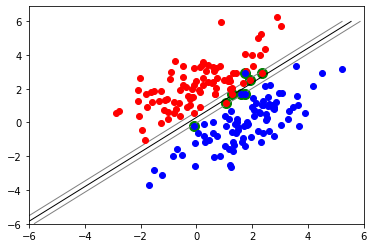

In [13]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
             
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

if __name__ == "__main__":
    import pylab as pl

    def gen_lin_separable_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[0.8, 0.6], [0.6, 0.8]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_non_lin_separable_data():
        mean1 = [-1, 2]
        mean2 = [1, -1]
        mean3 = [4, -4]
        mean4 = [-4, 4]
        cov = [[1.0,0.8], [0.8, 1.0]]
        X1 = np.random.multivariate_normal(mean1, cov, 50)
        X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 50)
        X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_lin_separable_overlap_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[1.5, 1.0], [1.0, 1.5]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def split_train(X1, y1, X2, y2):
        X1_train = X1[:90]
        y1_train = y1[:90]
        X2_train = X2[:90]
        y2_train = y2[:90]
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))
        return X_train, y_train

    def split_test(X1, y1, X2, y2):
        X1_test = X1[90:]
        y1_test = y1[90:]
        X2_test = X2[90:]
        y2_test = y2[90:]
        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))
        return X_test, y_test

    def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]

        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

        pl.axis("tight")
        pl.show()

    def plot_contour(X1_train, X2_train, clf):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()

    def test_linear():
        X1, y1, X2, y2 = gen_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM()
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)

    def test_non_linear():
        X1, y1, X2, y2 = gen_non_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(polynomial_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

    def test_soft():
        X1, y1, X2, y2 = gen_lin_separable_overlap_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(C=1000.1)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

        
    #test_linear()
    #test_non_linear()
    test_soft()

***2***

In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.svm import SVC
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

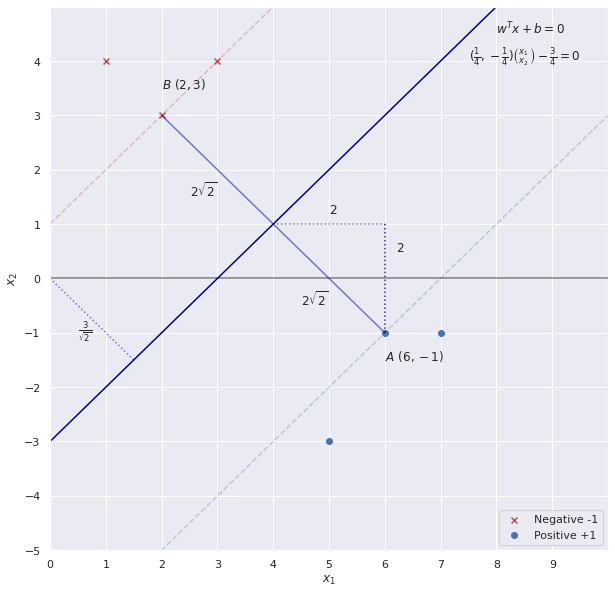

In [16]:
#Data set
x_neg = np.array([[3,4],[1,4],[2,3]])
y_neg = np.array([-1,-1,-1])
x_pos = np.array([[6,-1],[7,-1],[5,-3]])
y_pos = np.array([1,1,1])
x1 = np.linspace(-10,10)
x = np.vstack((np.linspace(-10,10),np.linspace(-10,10)))

#Data for the next section
X = np.vstack((x_pos, x_neg))
y = np.concatenate((y_pos,y_neg))

#Parameters guessed by inspection
w = np.array([1,-1]).reshape(-1,1)
b = -3

#Plot
fig = plt.figure(figsize = (10,10))
plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')
plt.plot(x1, x1  - 3, color = 'darkblue')
plt.plot(x1, x1  - 7, linestyle = '--', alpha = .3, color = 'b')
plt.plot(x1, x1  + 1, linestyle = '--', alpha = .3, color = 'r')
plt.xlim(0,10)
plt.ylim(-5,5)
plt.xticks(np.arange(0, 10, step=1))
plt.yticks(np.arange(-5, 5, step=1))

#Lines
plt.axvline(0, color = 'black', alpha = .5)
plt.axhline(0,color = 'black', alpha = .5)
plt.plot([2,6],[3,-1], linestyle = '-', color = 'darkblue', alpha = .5 )
plt.plot([4,6],[1,1],[6,6],[1,-1], linestyle = ':', color = 'darkblue', alpha = .5 )
plt.plot([0,1.5],[0,-1.5],[6,6],[1,-1], linestyle = ':', color = 'darkblue', alpha = .5 )

#Annotations
plt.annotate(s = '$A \ (6,-1)$', xy = (5,-1), xytext = (6,-1.5))
plt.annotate(s = '$B \ (2,3)$', xy = (2,3), xytext = (2,3.5))#, arrowprops = {'width':.2, 'headwidth':8})
plt.annotate(s = '$2$', xy = (5,1.2), xytext = (5,1.2) )
plt.annotate(s = '$2$', xy = (6.2,.5), xytext = (6.2,.5))
plt.annotate(s = '$2\sqrt{2}$', xy = (4.5,-.5), xytext = (4.5,-.5))
plt.annotate(s = '$2\sqrt{2}$', xy = (2.5,1.5), xytext = (2.5,1.5))
plt.annotate(s = '$w^Tx + b = 0$', xy = (8,4.5), xytext = (8,4.5))
plt.annotate(s = '$(\\frac{1}{4},-\\frac{1}{4}) \\binom{x_1}{x_2}- \\frac{3}{4} = 0$', xy = (7.5,4), xytext = (7.5,4))
plt.annotate(s = '$\\frac{3}{\sqrt{2}}$', xy = (.5,-1), xytext = (.5,-1))

#Labels and show
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc = 'lower right')
plt.show()

In [17]:
#Importing with custom names to avoid issues with numpy / sympy matrix
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

#Initializing values and computing H. Note the 1. to force to float type
m,n = X.shape
y = y.reshape(-1,1) * 1.
X_dash = y * X
H = np.dot(X_dash , X_dash.T) * 1.

#Converting into cvxopt format
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(-np.eye(m))
h = cvxopt_matrix(np.zeros(m))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Setting solver parameters (change default to decrease tolerance) 
cvxopt_solvers.options['show_progress'] = False
cvxopt_solvers.options['abstol'] = 1e-10
cvxopt_solvers.options['reltol'] = 1e-10
cvxopt_solvers.options['feastol'] = 1e-10

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

In [18]:
#w parameter in vectorized form
w = ((y * alphas).T @ X).reshape(-1,1)

#Selecting the set of indices S corresponding to non zero parameters
S = (alphas > 1e-4).flatten()

#Computing b
b = y[S] - np.dot(X[S], w)

#Display results
print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])

Alphas =  [0.0625     0.06249356]
w =  [ 0.24999356 -0.25000644]
b =  [-0.74996781]


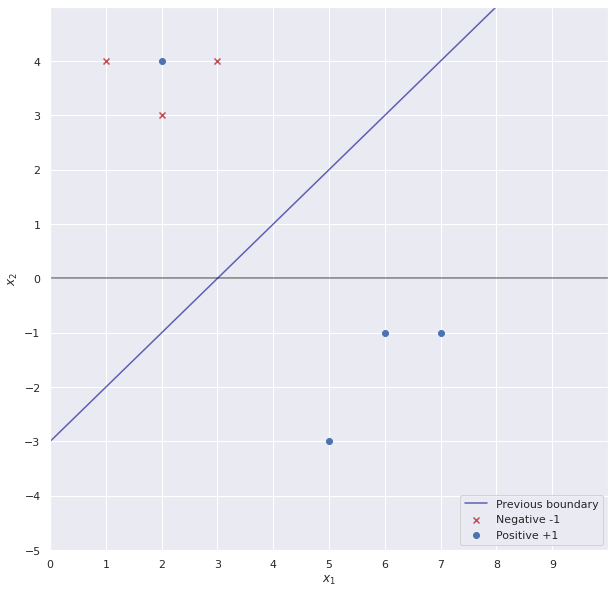

In [19]:
x_neg = np.array([[3,4],[1,4],[2,3]])
y_neg = np.array([-1,-1,-1])
x_pos = np.array([[6,-1],[7,-1],[5,-3],[2,4]])
y_pos = np.array([1,1,1,1])
x1 = np.linspace(-10,10)
x = np.vstack((np.linspace(-10,10),np.linspace(-10,10)))


fig = plt.figure(figsize = (10,10))
plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')
plt.plot(x1, x1  - 3, color = 'darkblue', alpha = .6, label = 'Previous boundary')
plt.xlim(0,10)
plt.ylim(-5,5)
plt.xticks(np.arange(0, 10, step=1))
plt.yticks(np.arange(-5, 5, step=1))

#Lines
plt.axvline(0, color = 'black', alpha = .5)
plt.axhline(0,color = 'black', alpha = .5)


plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.legend(loc = 'lower right')
plt.show()

#New dataset (for later)
X = np.array([[3,4],[1,4],[2,3],[6,-1],[7,-1],[5,-3],[2,4]] )
y = np.array([-1,-1, -1, 1, 1 , 1, 1 ])

In [20]:
#Initializing values and computing H. Note the 1. to force to float type
C = 10
m,n = X.shape
y = y.reshape(-1,1) * 1.
X_dash = y * X
H = np.dot(X_dash , X_dash.T) * 1.

#Converting into cvxopt format - as previously
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

#==================Computing and printing parameters===============================#
w = ((y * alphas).T @ X).reshape(-1,1)
S = (alphas > 1e-4).flatten()
b = y[S] - np.dot(X[S], w)

#Display results
print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])

Alphas =  [ 5.      6.3125  1.3125 10.    ]
w =  [ 0.25 -0.25]
b =  [-0.75]


In [21]:
clf = SVC(C = 10, kernel = 'linear')
clf.fit(X, y.ravel()) 

print('w = ',clf.coef_)
print('b = ',clf.intercept_)
print('Indices of support vectors = ', clf.support_)
print('Support vectors = ', clf.support_vectors_)
print('Number of support vectors for each class = ', clf.n_support_)
print('Coefficients of the support vector in the decision function = ', np.abs(clf.dual_coef_))

w =  [[ 0.25 -0.25]]
b =  [-0.75]
Indices of support vectors =  [0 2 3 6]
Support vectors =  [[ 3.  4.]
 [ 2.  3.]
 [ 6. -1.]
 [ 2.  4.]]
Number of support vectors for each class =  [2 2]
Coefficients of the support vector in the decision function =  [[ 5.      6.3125  1.3125 10.    ]]
